# Particle Swarm Optimization for SineWave Dataset

### Import Libraries

In [357]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [358]:
# Import Keras
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Activation

In [359]:
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.plotters import (plot_cost_history)

### Load dataset


In [360]:
sineData = pd.read_csv('./Sinewave.csv')

In [361]:
sineData.describe()

,sinewave
count,5001.000000
mean,0.000168
std,0.707207
min,-0.999986
25%,-0.688408
50%,0.005310
75%,0.725324
max,0.999986


In [362]:
sineData.head()

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


In [363]:
sineData.shape

(5001, 1)

### Split data to train and test set

In [364]:
sine_values = []
steps = 1
input_width = 5

x = []
y = []

for i in range(0, sineData.shape[0], steps):
    sine_values.append(sineData.at[i,'sinewave'])

for i in range(0, len(sine_values) - input_width, steps): 
    x.append(sine_values[i: i + input_width])
    y.append(sine_values[i + input_width])

x = np.reshape(x, [-1, input_width, 1])
y = np.reshape(y, [-1, 1])

In [365]:
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.20, shuffle=False)

In [366]:
trainX.shape

(3996, 5, 1)

In [367]:
testX.shape

(1000, 5, 1)

### Create neural network model using backpropagation

In [368]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(None, 1)))
model.add(Dense(1, activation='linear'))

In [442]:
# https://github.com/keras-team/keras/issues/7947
def rmse_nn(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [443]:
model.compile(loss=rmse_nn, optimizer='sgd', metrics=[rmse_nn, r_square_loss])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train Model using backpropagation

In [444]:
historyNN = model.fit(trainX, trainY, batch_size=50, epochs=20, validation_split=0.1)

Train on 3596 samples, validate on 400 samples
Epoch 1/20
3596/3596 [==============================] - 8s 2ms/step - loss: 0.0852 - rmse_nn: 0.0852 - r_square_loss: 0.0191 - val_loss: 0.0851 - val_rmse_nn: 0.0851 - val_r_square_loss: 0.0233
Epoch 2/20
3596/3596 [==============================] - 2s 431us/step - loss: 0.0846 - rmse_nn: 0.0846 - r_square_loss: 0.0190 - val_loss: 0.0841 - val_rmse_nn: 0.0841 - val_r_square_loss: 0.0226
Epoch 3/20
3596/3596 [==============================] - 1s 411us/step - loss: 0.0838 - rmse_nn: 0.0838 - r_square_loss: 0.0184 - val_loss: 0.0832 - val_rmse_nn: 0.0832 - val_r_square_loss: 0.0223
Epoch 4/20
3596/3596 [==============================] - 1s 397us/step - loss: 0.0830 - rmse_nn: 0.0830 - r_square_loss: 0.0181 - val_loss: 0.0826 - val_rmse_nn: 0.0826 - val_r_square_loss: 0.0218
Epoch 5/20
3596/3596 [==============================] - 2s 479us/step - loss: 0.0822 - rmse_nn: 0.0822 - r_square_loss: 0.0178 - val_loss: 0.0816 - val_rmse_nn: 0.0816 - v

### Model Training Performance

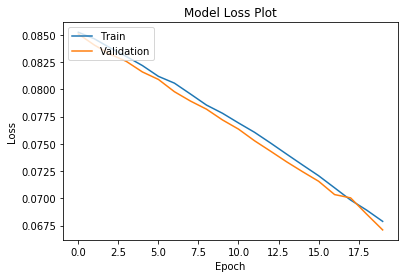

In [454]:
plt.plot(historyNN.history['loss'])
plt.plot(historyNN.history['val_loss'])
plt.title('Model Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test Neural Network Model - BackPropagation

In [452]:
lossNN = model.evaluate(testX, testY)

1000/1000 [==============================] - 0s 146us/step


In [453]:
print('The loss output for test dataset is: %f' % lossNN[0])

The loss output for test dataset is: 0.067104


### Plot the sine wave from the test set prediction vs actual

In [375]:
predictY = model.predict(testX)

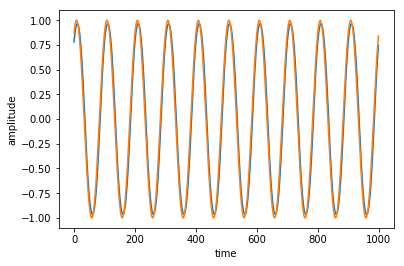

In [376]:
time = np.arange(predictY.shape[0])

plt.plot(time, predictY, testY)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

### Part 2 - Neural Network using GA

In [377]:
modelGA = Sequential()
modelGA.add(LSTM(32, return_sequences=False, input_shape=(None, 1), name='layer_1'))
modelGA.add(Dense(1, activation='linear', name='layer_2'))

In [378]:
modelGA.compile(loss="mean_squared_error", optimizer='sgd', metrics=["mean_squared_error", r_square_loss])
modelGA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (LSTM)               (None, 32)                4352      
_________________________________________________________________
layer_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Loss function for Pyswarm

In [445]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1))

In [428]:
# Get the loss value for each particle
def getFitness(params):
    layer_1 = modelGA.get_layer('layer_1').get_weights()
    layer_2 = modelGA.get_layer('layer_2').get_weights()
    
    layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
    layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
    layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
    layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
    layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

    layer1_W1 = params[0:layer1_W1_shape].reshape(layer_1[0].shape)
    layer1_W2 = params[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
    layer1_B = params[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
    layer2_W = params[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
    layer2_B = params[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)
    
    modelGA.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
    modelGA.get_layer('layer_2').set_weights([layer2_W, layer2_B])
    
    predY = modelGA.predict(trainX)
    loss = rmse(trainY.reshape(trainY.shape[0]), predY.reshape(trainY.shape[0]))
    return loss

In [429]:
# Computed loss for all particles
def f(params):
    print('Number of particles: %d' % params.shape[0])
    losses = np.array([getFitness(params[i]) for i in range(params.shape[0])])
    print('List of losses for all particles')
    print(losses)
    return losses

### Pyswarm algorithm

In [430]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

layer_1 = modelGA.get_layer('layer_1').get_weights()
layer_2 = modelGA.get_layer('layer_2').get_weights()
dimensions = (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[0].shape[0] * layer_1[0].shape[1]) + (layer_1[1].shape[0] * layer_1[1].shape[1]) + (layer_2[0].shape[0] * layer_2[0].shape[1]) +(layer_2[1].shape[0])

print("Number of params in Neural Network: %d" % dimensions)

optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=dimensions, options=options)

cost, pos = optimizer.optimize(f, iters=50)



2019-03-02 14:58:09,315 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}





































pyswarms.single.global_best:   0%|          |0/50

Number of params in Neural Network: 4385
Number of particles: 20







































pyswarms.single.global_best:   0%|          |0/50, best_cost=13




































pyswarms.single.global_best:   2%|▏         |1/50, best_cost=13

List of losses for all particles
[16.09386572 14.04286392 15.72491667 15.26946004 17.6489134  16.23777086
 14.99025789 14.24477598 14.81692274 15.86529524 15.8349588  14.64303822
 14.8896217  15.62132171 14.66467107 16.77240304 15.28026794 13.04812632
 15.75681363 16.35977631]
Number of particles: 20







































pyswarms.single.global_best:   2%|▏         |1/50, best_cost=13




































pyswarms.single.global_best:   4%|▍         |2/50, best_cost=13

List of losses for all particles
[28.62166195 29.66537364 28.61878187 30.21746838 32.80991469 28.58901165
 27.76975213 30.99974571 29.83592465 31.53821402 31.66014496 28.20342063
 30.27984993 30.95185591 27.47841644 30.98993045 31.63844929 27.62388906
 27.93019965 29.04805017]
Number of particles: 20







































pyswarms.single.global_best:   4%|▍         |2/50, best_cost=13




































pyswarms.single.global_best:   6%|▌         |3/50, best_cost=13

List of losses for all particles
[33.53309575 37.19122494 33.02261558 36.09260618 38.9693891  34.27985874
 31.80618645 39.28822671 38.12206063 40.878422   38.76594414 34.31722257
 37.23340978 37.42092786 33.44302741 36.51196104 38.03862089 34.96276423
 33.4398559  34.3124064 ]
Number of particles: 20







































pyswarms.single.global_best:   6%|▌         |3/50, best_cost=13




































pyswarms.single.global_best:   8%|▊         |4/50, best_cost=13

List of losses for all particles
[30.73450587 34.68777107 31.14714974 33.75542122 34.77399977 31.31613086
 29.34354267 36.03441758 36.79768184 38.47782259 36.65362229 32.85170586
 34.65153121 32.96457472 32.07782618 33.09087624 35.40960928 33.02386096
 31.7331283  31.86132191]
Number of particles: 20







































pyswarms.single.global_best:   8%|▊         |4/50, best_cost=13




































pyswarms.single.global_best:  10%|█         |5/50, best_cost=13

List of losses for all particles
[22.43925996 24.97001112 23.66944102 25.68148253 21.46634845 22.7451626
 20.91706718 24.08434259 25.42096263 26.49965406 26.81676101 25.15724221
 22.44252681 22.7385746  24.94872127 23.57832587 26.47730751 23.26909842
 22.83922055 21.65711626]
Number of particles: 20







































pyswarms.single.global_best:  10%|█         |5/50, best_cost=7.72




































pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=7.72

List of losses for all particles
[11.60070142 11.47324575 11.74271596 14.12271549  7.71742983 11.82592793
  8.54808304 10.02319568 10.89452924 13.01180659 12.99344687 12.91913605
  8.65937463  8.9343844  12.95050492 10.7161654  11.69596856  9.78305061
 11.61194575  9.03405748]
Number of particles: 20







































pyswarms.single.global_best:  12%|█▏        |6/50, best_cost=0.321




































pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=0.321

List of losses for all particles
[1.36743728 1.30295098 0.83623998 0.6699191  0.87895415 0.6617977
 0.72689144 0.47872521 0.64133319 0.84212772 1.39183853 1.17646437
 1.16876805 1.03401326 0.60961263 0.32125167 0.93863757 1.27676485
 0.52728269 1.07709422]
Number of particles: 20







































pyswarms.single.global_best:  14%|█▍        |7/50, best_cost=0.258




































pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=0.258

List of losses for all particles
[1.21876105 1.25765175 0.30243248 0.88796643 0.71266407 0.759373
 0.84036873 0.36518521 0.65478166 0.92445981 0.90389385 1.11318093
 0.81917819 0.95074767 0.45081131 0.52695113 1.3074086  1.63843787
 0.25818076 1.45199945]
Number of particles: 20







































pyswarms.single.global_best:  16%|█▌        |8/50, best_cost=0.258




































pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=0.258

List of losses for all particles
[1.10369406 1.40049424 1.54949832 0.76850898 4.39407721 0.56214703
 0.92312686 1.29174296 0.708158   0.90620947 1.27845403 1.01393319
 0.78041322 2.11517745 1.31118854 0.47233183 1.23996671 1.55071474
 1.55328039 1.56091631]
Number of particles: 20







































pyswarms.single.global_best:  18%|█▊        |9/50, best_cost=0.258




































pyswarms.single.global_best:  20%|██        |10/50, best_cost=0.258

List of losses for all particles
[2.63961828 2.73704289 3.33413194 1.51667612 5.70367385 1.72189913
 0.6530953  2.67452439 0.74394977 0.84987829 2.81789906 1.71940782
 5.31526021 3.23995556 3.36343301 0.63022722 1.57214694 1.51507168
 2.2147908  1.29200591]
Number of particles: 20







































pyswarms.single.global_best:  20%|██        |10/50, best_cost=0.258




































pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=0.258

List of losses for all particles
[3.77534357 2.39010989 2.53197418 1.00311632 4.04210604 2.15303317
 0.55126989 2.62602271 1.36298676 1.17822362 2.64156971 2.80812424
 6.8310495  2.88840634 3.10965329 1.21001348 1.0734312  0.27543506
 2.06474886 0.92283813]
Number of particles: 20







































pyswarms.single.global_best:  22%|██▏       |11/50, best_cost=0.258




































pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=0.258

List of losses for all particles
[2.68445812 1.21971994 0.93927518 0.62031735 1.60731121 1.75880731
 0.77356871 1.18472942 1.19765033 0.73487284 0.80497405 1.94640578
 4.83168182 0.79208078 0.92681349 1.05335008 1.1875363  0.46785745
 0.86938041 0.82306723]
Number of particles: 20







































pyswarms.single.global_best:  24%|██▍       |12/50, best_cost=0.247




































pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=0.247

List of losses for all particles
[1.32853529 1.01752189 0.37037145 1.52628638 1.05238589 1.45679137
 0.63338641 0.27143627 1.50080253 0.85788031 0.46383346 1.16425185
 1.98037068 0.39962089 1.12668382 1.91288731 2.171303   0.29165408
 0.24684312 0.28868748]
Number of particles: 20







































pyswarms.single.global_best:  26%|██▌       |13/50, best_cost=0.247




































pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=0.247

List of losses for all particles
[0.4054887  0.70658024 0.64053565 5.02092012 1.09393509 0.87410698
 0.27984301 0.40985875 8.51453535 5.16062686 0.34837901 0.85998778
 0.8209497  0.38763998 0.91716562 5.51715079 5.89667616 0.25333516
 0.26400256 1.05507582]
Number of particles: 20







































pyswarms.single.global_best:  28%|██▊       |14/50, best_cost=0.239




































pyswarms.single.global_best:  30%|███       |15/50, best_cost=0.239

List of losses for all particles
[0.72669419 0.98223775 1.75504824 2.54932293 0.98713666 0.28205808
 0.23852072 1.30140814 6.87066127 2.13569314 1.1510766  0.70487434
 0.59872745 1.5752786  1.5239206  4.85971237 6.26077705 0.34228102
 2.69917934 1.83983227]
Number of particles: 20







































pyswarms.single.global_best:  30%|███       |15/50, best_cost=0.239




































pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=0.239

List of losses for all particles
[0.35927284 1.39646835 2.17633281 1.16710815 1.10855165 0.42630272
 0.41379902 0.44865665 0.87693808 0.91325555 1.80677875 0.49417134
 0.99426661 2.19073039 0.50945004 1.74354485 2.03043194 0.39240453
 1.11323434 1.5731044 ]
Number of particles: 20







































pyswarms.single.global_best:  32%|███▏      |16/50, best_cost=0.239




































pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=0.239

List of losses for all particles
[1.13590721 0.99185206 1.71468628 0.82542521 1.41271154 0.57232171
 0.48889041 0.63865182 0.8338811  0.35838658 0.66368734 4.33171553
 1.146337   1.910767   0.40617245 0.55587338 0.39865833 0.40468291
 0.69939027 0.70637534]
Number of particles: 20







































pyswarms.single.global_best:  34%|███▍      |17/50, best_cost=0.167




































pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=0.167

List of losses for all particles
[1.30657263 0.46674075 0.79664311 0.95077722 1.88256375 0.67657854
 0.42259271 0.72597412 0.47632822 0.90409936 0.34654491 3.90114785
 0.84162889 1.04849296 0.42259577 0.41616865 0.77731024 0.36933237
 0.60883555 0.16717526]
Number of particles: 20







































pyswarms.single.global_best:  36%|███▌      |18/50, best_cost=0.151




































pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=0.151

List of losses for all particles
[1.00042193 0.15054399 0.72173681 0.58774985 3.04490502 0.64871561
 0.28045452 1.84448061 0.80248025 0.95956548 0.70248282 0.71979373
 0.35350971 0.32603473 0.90302596 0.53865466 0.50932694 0.27939351
 0.62521551 0.47378449]
Number of particles: 20







































pyswarms.single.global_best:  38%|███▊      |19/50, best_cost=0.151




































pyswarms.single.global_best:  40%|████      |20/50, best_cost=0.151

List of losses for all particles
[0.5267732  0.15248225 1.14769693 0.54314063 2.07325013 0.37533737
 0.18790713 1.93373442 1.13943252 0.92915799 0.87647756 0.80939813
 0.15991882 0.38388734 0.95426425 0.71279879 0.65015572 0.33140025
 0.85879121 0.64462058]
Number of particles: 20







































pyswarms.single.global_best:  40%|████      |20/50, best_cost=0.151




































pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=0.151

List of losses for all particles
[0.23738721 0.31423698 1.21291734 0.54621523 1.7344609  0.65266075
 0.1654562  1.0296767  1.20524605 0.59277959 0.8851773  0.70767744
 0.62231653 0.61248845 0.75411433 0.75856341 0.43885838 0.95233435
 0.97264507 0.66362324]
Number of particles: 20







































pyswarms.single.global_best:  42%|████▏     |21/50, best_cost=0.133




































pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=0.133

List of losses for all particles
[0.31468593 0.23232649 0.76594271 0.59261759 1.62969907 1.24570037
 0.13250394 0.2572487  1.01969518 0.19019337 0.33515959 0.48673667
 0.97688779 0.3515106  0.78492774 1.28662254 0.35763996 1.42558521
 0.91127228 0.42004592]
Number of particles: 20







































pyswarms.single.global_best:  44%|████▍     |22/50, best_cost=0.133




































pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=0.133

List of losses for all particles
[0.36506194 0.2669002  0.7324352  0.69408935 0.87643665 1.18447777
 0.15197065 0.81018921 0.58939019 0.52073854 0.22880528 0.22794886
 1.08542858 0.35381954 0.9455574  1.87732037 1.36432958 1.56670385
 0.49228954 0.23281494]
Number of particles: 20







































pyswarms.single.global_best:  46%|████▌     |23/50, best_cost=0.133




































pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=0.133

List of losses for all particles
[0.33838648 0.32454902 1.07895584 0.45483279 0.567788   0.73466114
 0.25654735 1.05185006 0.48857218 0.79721814 0.14525467 0.31535895
 0.6073235  0.19116724 1.01599598 2.11015652 2.81876554 0.99793417
 0.33730537 0.44514336]
Number of particles: 20







































pyswarms.single.global_best:  48%|████▊     |24/50, best_cost=0.133




































pyswarms.single.global_best:  50%|█████     |25/50, best_cost=0.133

List of losses for all particles
[0.16612017 0.4631379  1.25908584 0.154401   0.81025406 0.33663859
 0.19445033 0.72185476 0.51529393 0.86480284 0.3187815  0.74784739
 0.3135105  0.88333936 0.82031636 1.6353808  1.9206788  0.46589333
 0.32018373 0.45163039]
Number of particles: 20







































pyswarms.single.global_best:  50%|█████     |25/50, best_cost=0.133




































pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=0.133

List of losses for all particles
[0.22840353 0.41243298 1.57748933 0.25688823 0.63801471 0.4683709
 0.1815239  0.26335977 0.74325945 0.24961805 0.31484781 1.04992612
 0.14989693 1.23700252 0.81709765 1.55583644 0.54236181 0.36992211
 0.65657886 0.60123446]
Number of particles: 20







































pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=0.133




































pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=0.133

List of losses for all particles
[0.35022991 0.32060074 1.45459708 0.50696172 0.31930767 0.71233831
 0.16100969 0.56066239 0.88117847 0.26696811 0.22598359 0.68715059
 0.32733485 1.04791498 0.50181976 1.03651207 0.22021069 0.62851205
 0.73258222 0.43652366]
Number of particles: 20







































pyswarms.single.global_best:  54%|█████▍    |27/50, best_cost=0.133




































pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=0.133

List of losses for all particles
[0.31385363 0.28931642 1.28132333 0.58116991 0.59140342 0.79523728
 0.1495984  1.02871278 0.93061987 0.48018692 0.14795073 0.14184101
 0.40748567 0.48576956 0.6659194  0.39387404 0.45347938 0.59940976
 0.78515404 0.32377352]
Number of particles: 20







































pyswarms.single.global_best:  56%|█████▌    |28/50, best_cost=0.133




































pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=0.133

List of losses for all particles
[0.1458519  0.20424005 1.26768285 0.40801786 0.78130363 0.79609901
 0.18306373 1.03087709 0.88042766 0.77831637 0.13794865 0.31468379
 0.38331536 0.1541283  0.82663834 0.32503462 0.57460805 0.41521439
 0.88267301 0.5752177 ]
Number of particles: 20







































pyswarms.single.global_best:  58%|█████▊    |29/50, best_cost=0.133




































pyswarms.single.global_best:  60%|██████    |30/50, best_cost=0.133

List of losses for all particles
[0.21416622 0.25087506 1.14848418 0.29662945 0.49937426 0.29731013
 0.17674598 0.60634072 0.90616958 0.93877634 0.34160813 0.38479155
 0.33709038 0.30545893 0.68552904 0.92170097 0.4967945  0.48265846
 0.83648398 0.63497887]
Number of particles: 20







































pyswarms.single.global_best:  60%|██████    |30/50, best_cost=0.133




































pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=0.133

List of losses for all particles
[0.248338   0.19446152 1.1176244  0.46724137 0.32226397 1.24592466
 0.15560571 0.34758988 0.43539552 0.69558804 0.4991891  0.32707621
 0.22723853 0.41752182 0.67591182 1.69040007 0.41590874 0.90933123
 0.85430041 0.49069196]
Number of particles: 20







































pyswarms.single.global_best:  62%|██████▏   |31/50, best_cost=0.133




































pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=0.133

List of losses for all particles
[0.23225818 0.16207509 1.07634415 0.57842089 0.19226208 1.40872862
 0.15901861 0.96915306 0.38965189 0.70445449 0.40291179 0.19448016
 0.28453449 0.41909975 0.70344374 1.9279652  0.29941215 1.03680464
 0.77240182 0.19780131]
Number of particles: 20







































pyswarms.single.global_best:  64%|██████▍   |32/50, best_cost=0.133




































pyswarms.single.global_best:  66%|██████▌   |33/50, best_cost=0.133

List of losses for all particles
[0.13390502 0.17348863 0.86189917 0.54796671 0.25295223 1.09565025
 0.16265021 1.04646719 0.77886785 0.55075068 0.20543075 0.27052225
 0.39733573 0.4002882  0.63879899 1.96158765 0.51246995 0.76599557
 0.39196564 0.36043817]
Number of particles: 20







































pyswarms.single.global_best:  66%|██████▌   |33/50, best_cost=0.133




































pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=0.133

List of losses for all particles
[0.20516734 0.17401776 1.20346729 0.39870443 0.48008249 0.61454409
 0.14744409 0.63392657 1.25583888 0.49676701 0.16698666 0.58289101
 0.51656819 0.30481349 0.70460248 1.68892782 0.7856825  0.53730691
 0.45817228 0.41295054]
Number of particles: 20







































pyswarms.single.global_best:  68%|██████▊   |34/50, best_cost=0.126




































pyswarms.single.global_best:  70%|███████   |35/50, best_cost=0.126

List of losses for all particles
[0.310362   0.29326522 1.3755969  0.18767661 0.59651662 0.27675433
 0.12623665 0.41788678 1.58391214 0.31555445 0.18095796 0.85344207
 0.4462579  0.20073237 0.82808185 1.35611288 0.58558396 0.46131607
 0.76994671 0.4383319 ]
Number of particles: 20







































pyswarms.single.global_best:  70%|███████   |35/50, best_cost=0.126




































pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=0.126

List of losses for all particles
[0.29951746 0.26546338 1.32001576 0.31209234 0.52138931 0.25917318
 0.1378854  0.24822168 1.24681722 0.37640828 0.17557784 0.71837297
 0.21987576 0.42575491 0.59896307 1.41028288 0.22556791 0.47944029
 0.60319245 0.45958187]
Number of particles: 20







































pyswarms.single.global_best:  72%|███████▏  |36/50, best_cost=0.126




































pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=0.126

List of losses for all particles
[0.17652549 0.23789905 1.32147155 0.47879794 0.2026932  0.28515445
 0.15010523 0.49873592 0.46333455 0.21182447 0.14614167 0.43425302
 0.19729381 0.41518758 0.80350907 1.13186099 0.31274965 0.58749575
 0.67865872 0.34373214]
Number of particles: 20







































pyswarms.single.global_best:  74%|███████▍  |37/50, best_cost=0.126




































pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=0.126

List of losses for all particles
[0.20630542 0.23455429 0.97440489 0.4042498  0.22021292 0.43416366
 0.14197683 0.97359229 0.72433912 0.58969844 0.21532313 0.3166762
 0.28682693 0.34118959 0.87642375 0.79996796 0.45385962 0.5445158
 0.68569733 0.21969289]
Number of particles: 20







































pyswarms.single.global_best:  76%|███████▌  |38/50, best_cost=0.122




































pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=0.122

List of losses for all particles
[0.21891115 0.12159395 1.15930056 0.21228293 0.45522348 0.38756759
 0.13106792 0.97019119 0.73936252 0.79661177 0.26131989 0.20501151
 0.28272238 0.30995603 0.75573898 1.23706609 0.55984164 0.33894567
 0.48775306 0.37226933]
Number of particles: 20







































pyswarms.single.global_best:  78%|███████▊  |39/50, best_cost=0.107




































pyswarms.single.global_best:  80%|████████  |40/50, best_cost=0.107

List of losses for all particles
[0.1768543  0.20213309 1.10320171 0.29786374 0.65696657 0.36110891
 0.10733687 0.52076798 0.47288294 0.49240661 0.29443497 0.13793885
 0.20420273 0.27436149 0.45118302 1.5140731  0.45692058 0.54276459
 0.34585786 0.47361584]
Number of particles: 20







































pyswarms.single.global_best:  80%|████████  |40/50, best_cost=0.107




































pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=0.107

List of losses for all particles
[0.12986066 0.28872503 1.01938921 0.38350041 0.40369759 0.47762954
 0.1296921  0.22287134 0.24710542 0.35040627 0.19010385 0.20767481
 0.13417711 0.23719145 0.35598508 1.42785137 0.35198223 0.96208204
 0.33558309 0.44159188]
Number of particles: 20







































pyswarms.single.global_best:  82%|████████▏ |41/50, best_cost=0.106




































pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=0.106

List of losses for all particles
[0.13018536 0.2313979  0.9744945  0.39228339 0.26363498 0.6640244
 0.15355703 0.21539243 0.45423204 0.3606064  0.18291138 0.24275463
 0.10558797 0.23126285 0.47681055 1.40729938 0.19735472 0.97801018
 0.38030209 0.18128002]
Number of particles: 20







































pyswarms.single.global_best:  84%|████████▍ |42/50, best_cost=0.106




































pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=0.106

List of losses for all particles
[0.11768179 0.11350446 0.71226798 0.34806435 0.64616374 0.62689513
 0.17409284 0.2002265  0.60709267 0.4794755  0.27054021 0.21912931
 0.18396857 0.3570777  0.54230884 1.25251339 0.36995946 0.42260492
 0.37551871 0.36119362]
Number of particles: 20







































pyswarms.single.global_best:  86%|████████▌ |43/50, best_cost=0.106




































pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=0.106

List of losses for all particles
[0.10744191 0.1683692  0.66285313 0.2827577  1.0670568  0.65427593
 0.14732347 0.2167775  0.50773551 0.39245033 0.35427897 0.21764632
 0.32862451 0.29793872 0.43641318 0.69163746 0.60502981 0.31485916
 0.56435738 0.65806146]
Number of particles: 20







































pyswarms.single.global_best:  88%|████████▊ |44/50, best_cost=0.106




































pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=0.106

List of losses for all particles
[0.11078883 0.28151244 0.89253698 0.15937265 1.00259793 0.59029476
 0.10673077 0.15877699 0.40880188 0.18295417 0.35695945 0.18983479
 0.35365536 0.51515987 0.22720732 0.58305121 0.44054095 0.5448268
 0.60583614 0.52903812]
Number of particles: 20







































pyswarms.single.global_best:  90%|█████████ |45/50, best_cost=0.106




































pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=0.106

List of losses for all particles
[0.11439119 0.26851842 1.0834162  0.12608944 0.58576192 0.75500542
 0.13460224 0.33237554 0.42478539 0.15501348 0.21516639 0.11838877
 0.26218995 0.46805066 0.37279569 0.70813822 0.19305259 0.57104845
 0.53420598 0.14162887]
Number of particles: 20







































pyswarms.single.global_best:  92%|█████████▏|46/50, best_cost=0.0988




































pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=0.0988

List of losses for all particles
[0.12748475 0.1456869  1.31686601 0.09881684 0.32567248 0.76457204
 0.18017705 0.2858754  0.49323046 0.17193351 0.14172547 0.10091055
 0.13325161 0.29244027 0.61889587 1.2489189  0.24879329 0.4751286
 0.29665353 0.25616911]
Number of particles: 20







































pyswarms.single.global_best:  94%|█████████▍|47/50, best_cost=0.0988




































pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=0.0988

List of losses for all particles
[0.13245571 0.12167562 1.53478457 0.2083861  0.7123124  0.38650569
 0.18771763 0.20751858 0.58281693 0.27469204 0.20256069 0.17974856
 0.11809953 0.20650115 0.62423766 1.91102214 0.22268355 0.39065599
 0.24693691 0.36947933]
Number of particles: 20







































pyswarms.single.global_best:  96%|█████████▌|48/50, best_cost=0.0988




































pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=0.0988

List of losses for all particles
[0.14673934 0.12764288 1.35834483 0.3326591  1.05784575 0.22975338
 0.11901528 0.18884001 0.45992764 0.31472279 0.3440851  0.23929362
 0.16849162 0.20971482 0.34731384 1.47657384 0.14920415 0.33601609
 0.35753619 0.35441269]
Number of particles: 20







































pyswarms.single.global_best:  98%|█████████▊|49/50, best_cost=0.0881




































pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.0881




































2019-03-02 15:05:09,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08814329879892738, best pos: [-0.02514773  0.17646692 -0.37365008 ... -0.2593118  -0.95572563
  0.40355033]


List of losses for all particles
[0.20697627 0.24063233 1.30655824 0.31225573 1.00152663 0.25391254
 0.09240415 0.1716728  0.22891094 0.15417872 0.4198473  0.24553019
 0.20329018 0.24411249 0.20148165 1.06295699 0.0881433  0.78218947
 0.37424598 0.2134111 ]


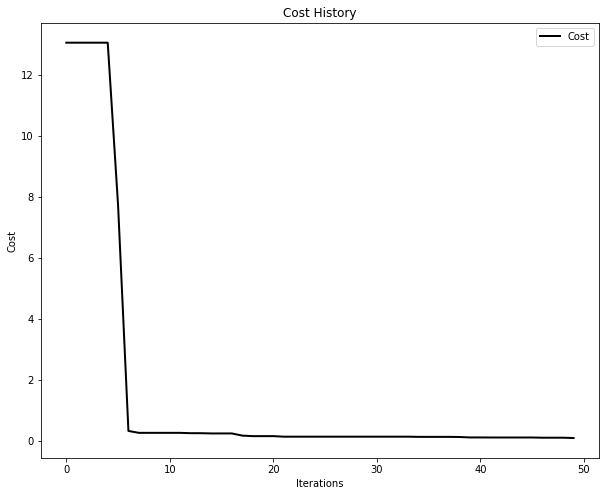

In [431]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

### Creating the Neural Network with the final optimized params using GA

In [446]:
layer_1 = modelGA.get_layer('layer_1').get_weights()
layer_2 = modelGA.get_layer('layer_2').get_weights()

layer1_W1_shape = (layer_1[0].shape[0] * layer_1[0].shape[1])
layer1_W2_shape = layer1_W1_shape + (layer_1[1].shape[0] * layer_1[1].shape[1])
layer1_B_shape = layer1_W2_shape + (layer_1[2].shape[0])
layer2_W_shape = layer1_B_shape + (layer_2[0].shape[0] * layer_2[0].shape[1])
layer2_B_shape = layer2_W_shape + (layer_2[1].shape[0])

layer1_W1 = pos[0:layer1_W1_shape].reshape(layer_1[0].shape)
layer1_W2 = pos[layer1_W1_shape:layer1_W2_shape].reshape(layer_1[1].shape)
layer1_B = pos[layer1_W2_shape:layer1_B_shape].reshape(layer_1[2].shape)
layer2_W = pos[layer1_B_shape:layer2_W_shape].reshape(layer_2[0].shape)
layer2_B = pos[layer2_W_shape:layer2_B_shape].reshape(layer_2[1].shape)

modelGA.get_layer('layer_1').set_weights([layer1_W1, layer1_W2, layer1_B])
modelGA.get_layer('layer_2').set_weights([layer2_W, layer2_B])

### Checking the performance of NN using GA

In [447]:
predictY = modelGA.predict(testX)

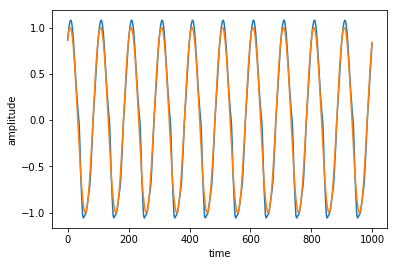

In [448]:
time = np.arange(predictY.shape[0])

plt.plot(time, predictY, testY)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.show()

In [449]:
lossNN_GA = modelGA.evaluate(testX, testY)

1000/1000 [==============================] - 0s 133us/step


In [450]:
print('The loss output for test dataset is: %f' % lossNN_GA[0])

The loss output for test dataset is: 0.007762


### Conclusion

In [455]:
print('We see that the loss output for test dataset using Back Propagation is: %f, while the loss output using GA is: %f' % (lossNN[0], lossNN_GA[0]))

We see that the loss output for test dataset using Back Propagation is: 0.067104, while the loss output using GA is: 0.007762


#### References
- https://pyswarms.readthedocs.io/en/latest/examples/visualization.html
- https://keras.io/getting-started/sequential-model-guide/